In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Talia Kurtz"
__contact__   = "talia.kurtz@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import csv
import pandas as pd

In [3]:
#Notes for the Assignment
#first step find the dmin values 
#to get the dmin from the observations by taking the distance from all observations to the other observations and then take the minimum distance to the nearest observation
#and then you will save that distance to a list and do for ALL observations and then take the average of that list

In [4]:
# z1 is now (0,0)
# z2 is now (1,0)
# z3 is now (0,1)
# z4 is now (1,1)
# x2, y2 is now just 1
# x1, y1 are now zero
def bilinear(x,y,ROI):
    rel_x = x -int(np.floor(x)) # in the equation this is the normal x
    rel_y = y - int(np.floor(y)) #in the equation this is the normal y
    z1 = analysis_matrix[int(np.floor(y)), int(np.floor(x)), ROI] #Here what we need to think about is that point in the middle and rounding down and up the index to get them to zeros and ones.
    z2 = analysis_matrix[int(np.ceil(y)), int(np.floor(x)), ROI] #We are doing things in terms of the index
    z3 = analysis_matrix[int(np.ceil(y)), int(np.ceil(x)), ROI]
    z4 = analysis_matrix[int(np.floor(y)), int(np.ceil(x)), ROI]
    
    p =(((rel_x-1)*(rel_y-1)*z1) - ((rel_x)*(rel_y-1)*z2) + (((rel_x)*(rel_y))*z3) - ((rel_x-1)*(rel_y)*z4))
    return p

In [6]:
### Create function for Cressman Analysis ###

def cressman_weights(dik, R):
    if(dik<= R):
        weight = (R**2 - dik**2)/(R**2 + dik**2)
    elif(dik > R):
        weight = 0
    else:
        print("You have really goofed up")
    return weight

In [7]:
### Read in observations ###
file = open('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/01-Function_Fitting/RAOBs_201903131200.txt')
csvreader = csv.reader(file)
###########################################################################################################################
rows = []
for row in csvreader:
        rows.append(row)
rows #Reading in the data this way because there are no headers and there are /n 

[['CWPL', '51.47', '-90.20', '5460.0', '285.0', '29.0'],
 ['CWQI', '43.83', '-66.00', '5540.0', '325.0', '41.0'],
 ['CWSE', '53.55', '-113.90', '5360.0', '280.0', '12.0'],
 ['CYAH', '53.75', '-73.60', '5340.0', '300.0', '70.0'],
 ['CYBK', '64.30', '-96.00', '5220.0', '95.0', '17.0'],
 ['CYCB', '69.10', '-105.10', '5190.0', '245.0', '32.0'],
 ['CYEU', '80.00', '-85.80', '4890.0', '200.0', '40.0'],
 ['CYEV', '68.30', '-133.40', '5210.0', '245.0', '37.0'],
 ['CYFB', '63.75', '-68.50', '5140.0', '290.0', '17.0'],
 ['CYJT', '48.53', '-58.50', '5360.0', '280.0', '45.0'],
 ['CYLT', '82.52', '-62.20', '4970.0', '255.0', '21.0'],
 ['CYMO', '51.27', '-80.60', '5450.0', '275.0', '37.0'],
 ['CYPH', '58.47', '-78.00', '5180.0', '285.0', '25.0'],
 ['CYQD', '53.97', '-101.10', '5370.0', '250.0', '31.0'],
 ['CYRB', '74.72', '-94.90', '5020.0', '250.0', '72.0'],
 ['CYSA', '43.93', '-60.00', '5490.0', '300.0', '21.0'],
 ['CYSM', '60.02', '-111.90', '5230.0', '300.0', '32.0'],
 ['CYUX', '68.78', '-81.20'

In [8]:
list_name = rows
df = pd.DataFrame (list_name, columns= ['Station ID', 'Lat', 'Lon', '500 mb Height', '500mb Wind Dir', '500mb Wind Speed'])
obs_lon = df['Lon'].astype(float)   #Getting the values to be floats.
obs_lat = df['Lat'].astype(float) #Getting the values to be floats.
obs_lon_rads = obs_lon*(np.pi/180)   #Getting from degrees to radians 
obs_lat_rads = obs_lat*(np.pi/180)  #Getting from degrees to radians
height = df['500 mb Height'].astype(float)  #Getting the values to be floats.
fobs = np.array(height)  #Pandas made it a series so we need to get it back into an array
#print(fobs)

In [9]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x = 18.9 #x_o (NW corner of map i.e. the (0,0) array memember)
y = -6.3 #y_o (NW corner of map i.e. the (0,0) array memember)
delta_x = 1.27
delta_y = 1.27 #spacing of our points 
######################################################################
#Making the points on the map. Analysis points 
x_step = x + np.arange(22)*delta_x
y_step = y + np.arange(28)*delta_y

grid_x, grid_y = np.meshgrid(x_step,y_step)

In [10]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
#Longitude (from grid to longitude)
map_proj = 1/(15e6)
rho = 6371 * 1e5 #radius of Earth
lambda_o = -115
phi_o = 60*(np.pi/180)   #Converting to radians

#We are converting it from cm to longitude and latitude so that we can plot it 
##############################################################################
#converting the longitude from x-values to longitude  
proj_lon = np.arctan(grid_y/grid_x)*(180/np.pi) + lambda_o    #The projection in python has to be in latitude and longitude so these two steps are to go to lat/lon for the projection
#Converting the y-values to latitude values
proj_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((grid_x/map_proj)**2+(grid_y/map_proj)**2)/(rho*(1+np.sin(phi_o)))))) 
  

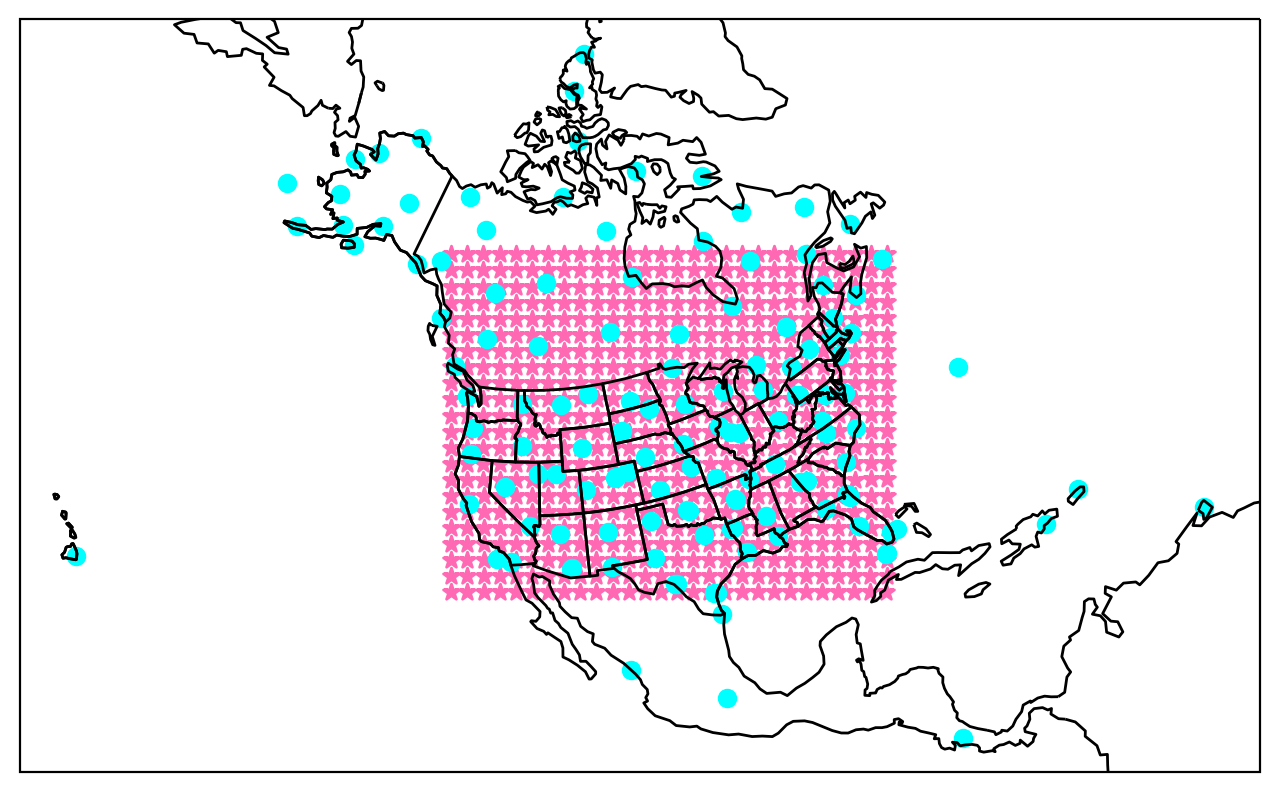

In [11]:
#convert the latitude and longitude form the text file and put them in the (x,y) form
#Trying to find sigma (image scale factor)
# sigma = (1 +sine (phi_o))/(1+sine(phi)) where phi is the latitude
phi_o = 60*(np.pi/180)


sigma_obs = (1 + np.sin(phi_o))/(1+np.sin(obs_lat_rads)) #this is our image scale factor
#print(sigma_obs)

#Determine the radius of any latitude circle 
lat_circle_radius = rho * sigma_obs*(np.cos(obs_lat_rads)) #this is the little r 
#print(lat_circle_radius)

#Solve for lambda which is the deviation of longitude from the standard longitude ( longitude of a point - lambda_o)
lambda_obs = ((obs_lon_rads)-(lambda_o*(np.pi/180)))
#print(lambda_obs)

#Now we are solving the observations for x 
x_obs = rho*sigma_obs*(np.cos(obs_lat_rads))*(np.cos(lambda_obs)) *map_proj 
#Now we are solving the observations for y 
y_obs = rho*sigma_obs*(np.cos(obs_lat_rads))*(np.sin(lambda_obs))* map_proj

x_obs = np.array(x_obs)
y_obs = np.array(y_obs)

#print(x_obs)
#print(y_obs)

obs_lon = np.arctan(y_obs/x_obs)*(180/np.pi) + lambda_o

#Converting the y-values to latitude values
obs_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_obs/map_proj)**2+(y_obs/map_proj)**2)/(rho*(1+np.sin(phi_o)))))) 
#x,y coords for our observations 


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(proj_lon, proj_lat,transform=ccrs.PlateCarree(), marker ="*", color = 'hotpink')
ax1.scatter(obs_lon, obs_lat, transform=ccrs.PlateCarree(), color = "cyan")

In [12]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin
distance_list = []
min_val = []
for i in range(135):
    r = ((x_obs[i]-x_obs)**2+(y_obs[i]-y_obs)**2)**(1/2)
    r.sort()
    min_val.append(r[1])

#dmin is the average distance between observations
dmin = np.mean(min_val)
####################################################################
R1= 4 * dmin
R2= 2.5 * dmin
R3= 1.5 * dmin

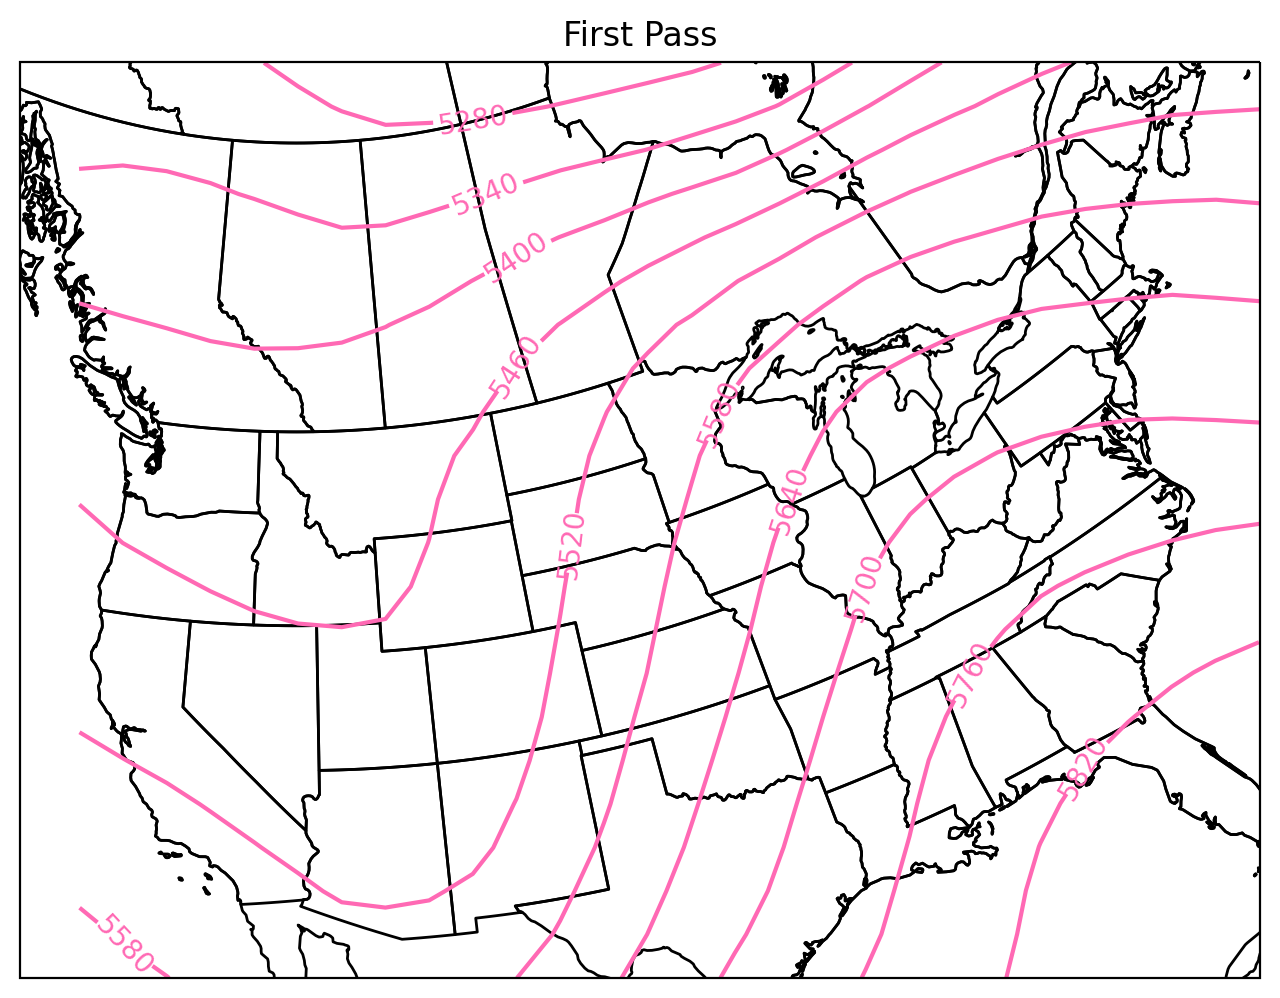

In [23]:


### First analysis, no successive corrections ###
##Showing Number #4:
Ro_vals = np.array([R1,R2,R3])


ROI_1 = Ro_vals[0]
y_cols = 28
x_cols = 22
#Make two empty arrays one for the observations and one for the Analysis 

analysis_matrix = np.empty((y_cols, x_cols, len(Ro_vals)))

for j in range(len(grid_x)):
    for k in range(len(grid_x[0])):
        x_rel = grid_x[j,k] - x_obs   #This is the distance in the x 
        y_rel = grid_y[j,k] - y_obs   #This is the distance in the y. 
            #This will the distance formula so we are getting the radius here remember the bubble with the points.
        radius = ((x_rel**2 + y_rel**2)**(1/2)) 
        index_ROI = np.where(radius <= ROI_1)[0]

        
        weights_matrix = np.zeros(len(x_obs))
        for i in index_ROI:
            w = cressman_weights(radius[i], ROI_1)
            weights_matrix[i] = w
            
        analysis_matrix[j, k, 0] = np.sum(weights_matrix * fobs) / np.sum(weights_matrix)

### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis_matrix[:,:,0],colors='hotpink',levels = np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(0,8000,60))
plt.title("First Pass")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/02-Successive_Corrections/First_Pass.png')

In [14]:
### Next Analyses ###
#Second Pass
# the x coord of observations minus the x0 divided by the spacing of the points this will be the same for y
#it is for bilinear
index_x = ((x_obs - x)/delta_x)
index_y = ((y_obs - y)/delta_y)

ROI_2 = Ro_vals[1]
#finding analysis values at the observation locations. We have the analysis value at the analysis location. 
bilinear_result = np.zeros(len(x_obs))   #
for i in range(len(index_x)):
    if (index_x[i]>= 0) and (index_x[i] < 21) and (index_y[i] >= 0) and (index_y[i] < 27):      #this is the ones that in our grid and we need to use the bilinear here
        p = bilinear(index_x[i], index_y[i], 0)  #you are using the first index of the analysis matrix 
    else:
        x_dist_analysis = x_obs[i] - grid_x
        y_dist_analysis = y_obs[i] - grid_y
        radius_analysis = ((x_dist_analysis)**2 + (y_dist_analysis)**2)**(1/2)   #this is the distance formula
        vals_analysis = np.where(radius_analysis <= Ro_vals[0])    #is it in our ROI?
        weights_analysis = np.zeros(grid_x.shape)
   
        for j in vals_analysis[0]:  #for the outer points that aren't in the pink star grid. They still have (x,y)
            for k in vals_analysis[1]:
                weights_cressman_analysis = cressman_weights(radius_analysis[j,k], Ro_vals[0])
                weights_analysis[j,k] = weights_cressman_analysis
        p = np.sum(weights_analysis*analysis_matrix[:,:,0])/np.sum(weights_analysis)   
    bilinear_result[i] = p

C:\Users\research\AppData\Local\Temp\ipykernel_9452\4011685166.py:25: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_analysis*analysis_matrix[:,:,0])/np.sum(weights_analysis)


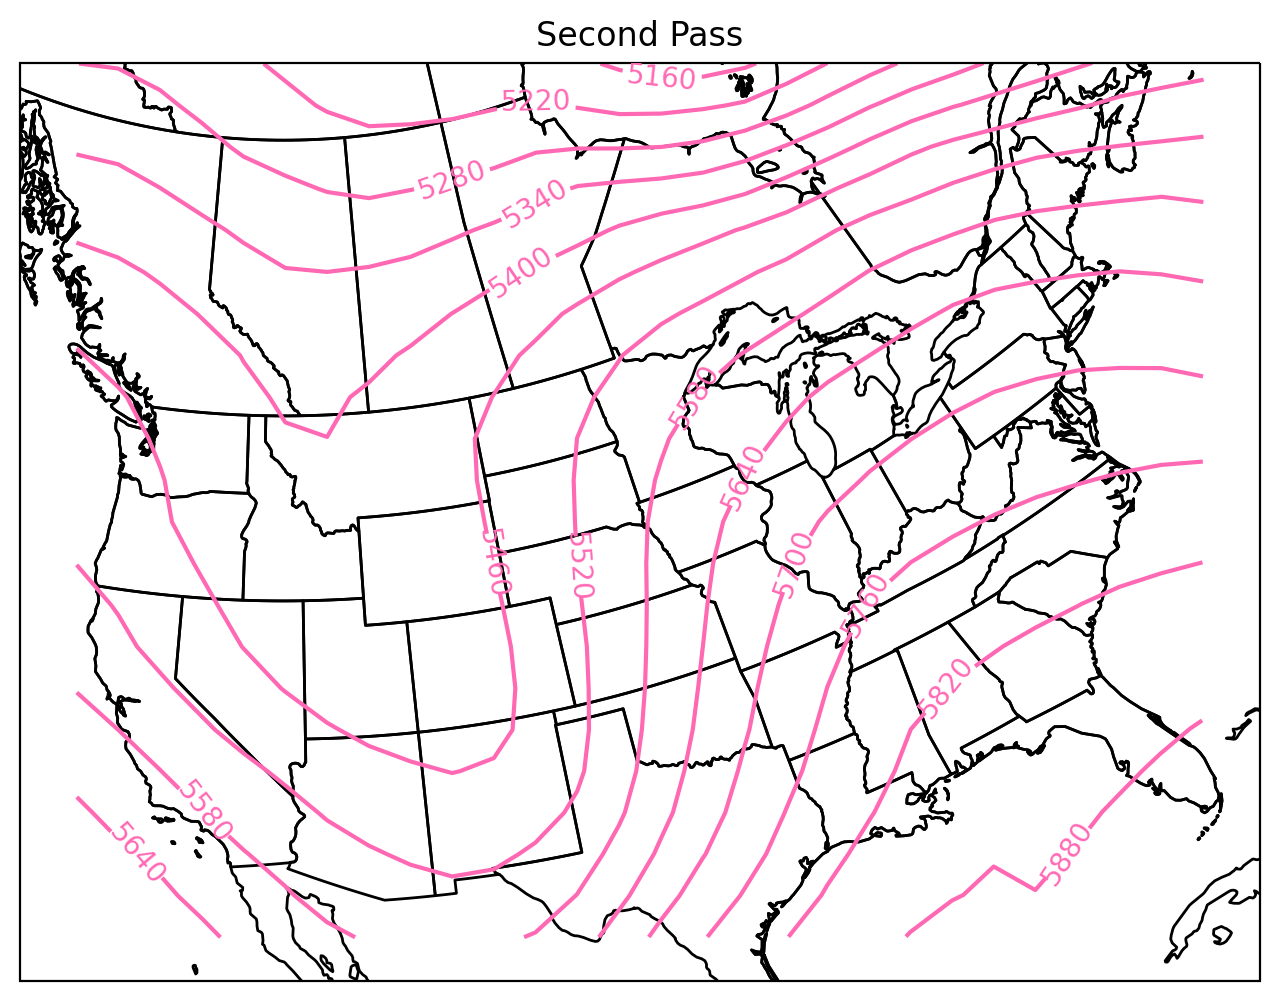

In [24]:
#now it is time for the second pass
for j in range(len(grid_x)):
    for k in range(len(grid_x[0])):
        x_distance = grid_x[j,k] - x_obs
        y_distance = grid_y[j,k] - y_obs
        radius = ((x_distance)**2 + (y_distance)**2)**(1/2)
        index_ROI = np.where(radius <= Ro_vals[1])[0]

        weights_matrix = np.zeros(len(x_obs))
        for i in index_ROI:
            w = cressman_weights(radius[i], ROI_2)
            weights_matrix[i] = w
            
        analysis_matrix[j, k, 1] = analysis_matrix[j,k,0] + (np.nansum(weights_matrix*(fobs-bilinear_result))/ np.nansum(weights_matrix))

### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis_matrix[:,:,1],colors='hotpink',levels = np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(0,8000,60))
plt.title("Second Pass")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/02-Successive_Corrections/Second_Pass.png')

In [16]:
# the x coord of observations minus the x0 divided by the spacing of the points this will be the same for y
#it is for bilinear
index_x = ((x_obs - x)/delta_x)
index_y = ((y_obs - y)/delta_y)

ROI_3 = Ro_vals[2]

#finding analysis values at the observation locations. We have the analysis value at the analysis location. 
bilinear_result2 = np.zeros(len(x_obs))
for i in range(len(index_x)):
    if (index_x[i]>= 0) and (index_x[i] < 21) and (index_y[i] >= 0) and (index_y[i] < 27):      #this is the ones that in our grid and we need to use the bilinear here
        p = bilinear(index_x[i], index_y[i], 1)  #you are using the first index of the analysis matrix 
        #print(p)
    else:
        x_dist_analysis = x_obs[i] - grid_x
        y_dist_analysis = y_obs[i] - grid_y
        radius_analysis = ((x_dist_analysis)**2 + (y_dist_analysis)**2)**(1/2)   #this is the distance formula
        vals_analysis = np.where(radius_analysis <= Ro_vals[1])    #is it in our ROI?
        weights_analysis = np.zeros(grid_x.shape)
   
        for j in vals_analysis[0]:  #for the outer points that aren't in the pink star grid. They still have (x,y)
            for k in vals_analysis[1]:
                weights_cressman_analysis = cressman_weights(radius_analysis[j,k], Ro_vals[1])
                weights_analysis[j,k] = weights_cressman_analysis
                #print(weights_analysis)
        p = np.sum(weights_analysis*analysis_matrix[:,:,1])/np.sum(weights_analysis)
    bilinear_result2[i] = p
print(bilinear_result2)

[5447.55696486 5524.96259355 5350.02527577 5273.09981954 5203.19337209
 5186.97143214           nan 5270.8039722  5143.54711669 5436.14763285
           nan 5451.29259768 5239.56233866 5377.94054592           nan
 5466.96237552 5244.47118783           nan 5249.79942249 5271.66689732
 5325.16029724 5231.89736293 5359.88822058 5435.17093147 5428.09643198
 5393.62412417 5473.58706124 5538.15220428           nan 5711.3576906
           nan 5463.28634036 5647.61143123 5535.6575506  5280.21873654
 5375.93494037 5633.7220107  5774.66442479           nan 5495.95840691
 5817.35499599 5778.07747899 5418.31862351 5786.1417506            nan
 5670.48504515 5766.51978698 5505.07820816           nan 5632.46657054
 5816.53528488 5758.06831115 5535.99561934 5477.50183231 5686.76882106
 5531.0138795  5479.50105714 5683.8450295  5675.74158743 5665.04624996
 5533.90148104 5898.49009375 5282.30972719 5818.95430856 5503.99922432
 5605.40997798 5689.64070858 5436.79051903 5430.91591335 5631.53977571
 5776.2

C:\Users\research\AppData\Local\Temp\ipykernel_9452\792759211.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_analysis*analysis_matrix[:,:,1])/np.sum(weights_analysis)


In [ ]:
print(p)

C:\Users\research\AppData\Local\Temp\ipykernel_9452\1392022568.py:12: RuntimeWarning: invalid value encountered in double_scalars
  analysis_matrix[j, k, 2] = analysis_matrix[j,k,1] + (np.nansum(weights_matrix*(fobs-bilinear_result2))/ np.nansum(weights_matrix))


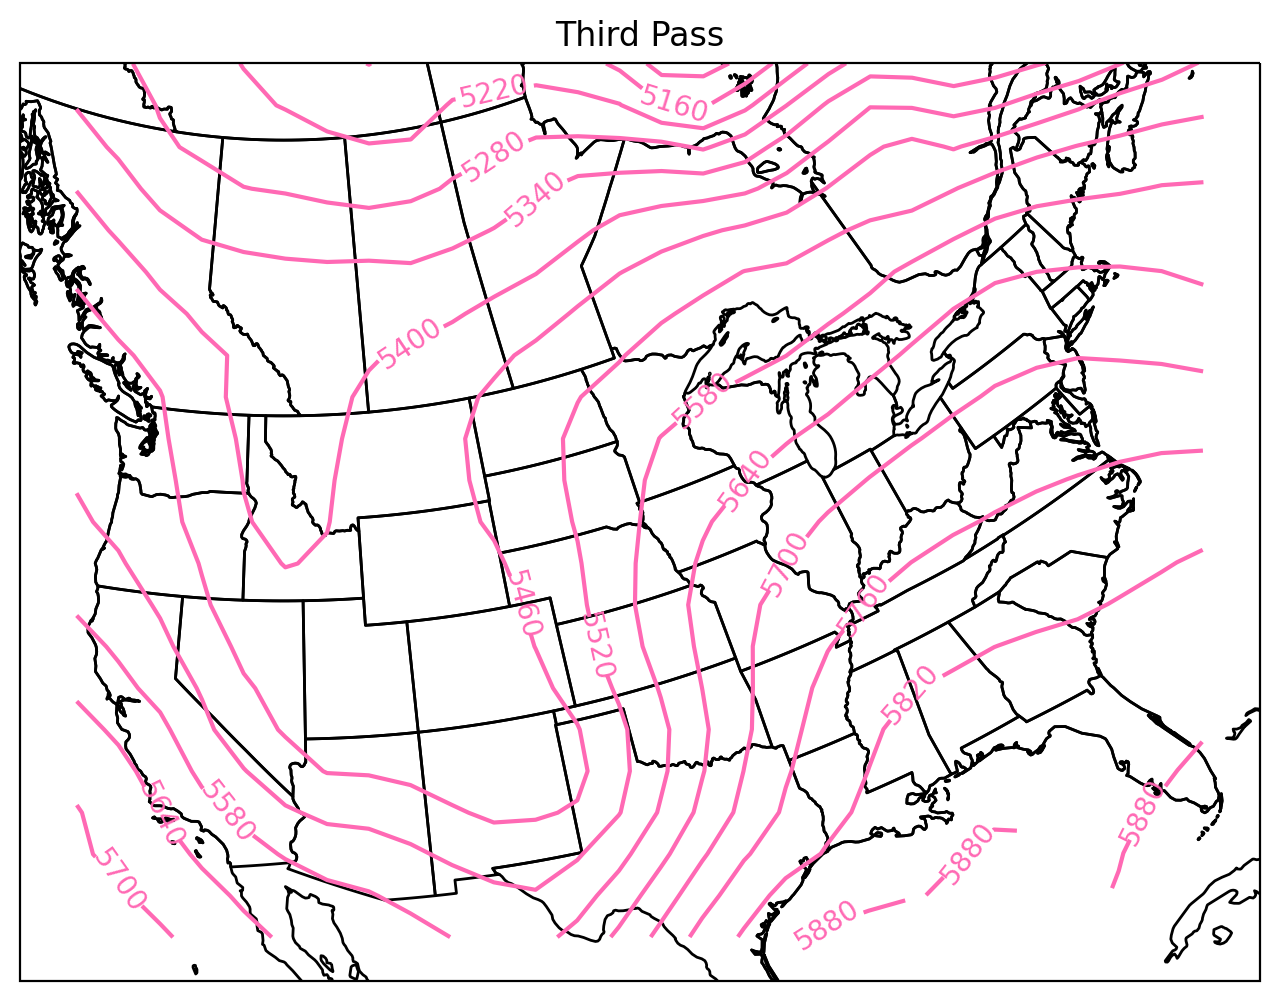

In [25]:
#now it is time for the third pass
for j in range(len(grid_x)):
    for k in range(len(grid_x[0])):
        x_distance = grid_x[j,k] - x_obs
        y_distance = grid_y[j,k] - y_obs
        radius = ((x_distance)**2 + (y_distance)**2)**(1/2)
        index_ROI = np.where(radius <= Ro_vals[2])[0]
        weights_matrix = np.zeros(len(x_obs))
        for i in index_ROI:
            w = cressman_weights(radius[i], ROI_3)
            weights_matrix[i] = w
        analysis_matrix[j, k, 2] = analysis_matrix[j,k,1] + (np.nansum(weights_matrix*(fobs-bilinear_result2))/ np.nansum(weights_matrix))

### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis_matrix[:,:,2],colors='hotpink',levels = np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(0,8000,60))
plt.title("Third Pass")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/02-Successive_Corrections/Third_Pass.png')

In [18]:
# the x coord of observations minus the x0 divided by the spacing of the points this will be the same for y
#it is for bilinear
index_x = ((x_obs - x)/delta_x)
index_y = ((y_obs - y)/delta_y)


#finding analysis values at the observation locations. We have the analysis value at the analysis location. 
bilinear_result3 = np.zeros(len(x_obs))
for i in range(len(index_x)):
    if (index_x[i]>= 0) and (index_x[i] < 21) and (index_y[i] >= 0) and (index_y[i] < 27):      #this is the ones that in our grid and we need to use the bilinear here
        p = bilinear(index_x[i], index_y[i], 2)  #you are using the first index of the analysis matrix 
    else:
        x_dist_analysis = x_obs[i] - grid_x
        y_dist_analysis = y_obs[i] - grid_y
        radius_analysis = ((x_dist_analysis)**2 + (y_dist_analysis)**2)**(1/2)   #this is the distance formula
        vals_analysis = np.where(radius_analysis <= Ro_vals[2])    #is it in our ROI?
        weights_analysis = np.zeros(grid_x.shape)
   
        for j in vals_analysis[0]:  #for the outer points that aren't in the pink star grid. They still have (x,y)
            for k in vals_analysis[1]:
                weights_cressman_analysis = cressman_weights(radius_analysis[j,k], Ro_vals[2])
                weights_analysis[j,k] = weights_cressman_analysis
                #print(weights_analysis)
        p = np.sum(weights_analysis*analysis_matrix[:,:,2])/np.sum(weights_analysis)
    bilinear_result3[i] = p
print(bilinear_result3)

[5457.02610202 5540.09495548 5359.5017243  5322.50116199           nan
           nan           nan           nan           nan           nan
           nan 5451.9737703            nan 5370.20702578           nan
 5483.71041799 5229.54851147           nan           nan           nan
 5303.74135416 5249.95653642           nan 5452.93580895           nan
 5387.56310117 5451.88350323 5546.94591631           nan 5712.56799338
           nan 5445.79335778 5654.34237692 5483.56693323           nan
           nan 5616.479865   5789.87771674           nan 5504.0943411
 5821.57789361 5778.23764207 5395.64795518           nan           nan
 5668.14965703 5770.34693262 5502.94286832           nan 5636.46043095
 5814.73220959           nan 5512.91852194 5463.18948845 5680.09877745
 5556.38366898 5465.34677758 5676.63009788 5666.41303677 5664.827958
 5540.4267218  5889.55440023           nan 5820.41642723 5493.99433279
 5614.9992093  5674.83571982 5440.76932393 5419.81926636 5621.2821147
 5777.7085

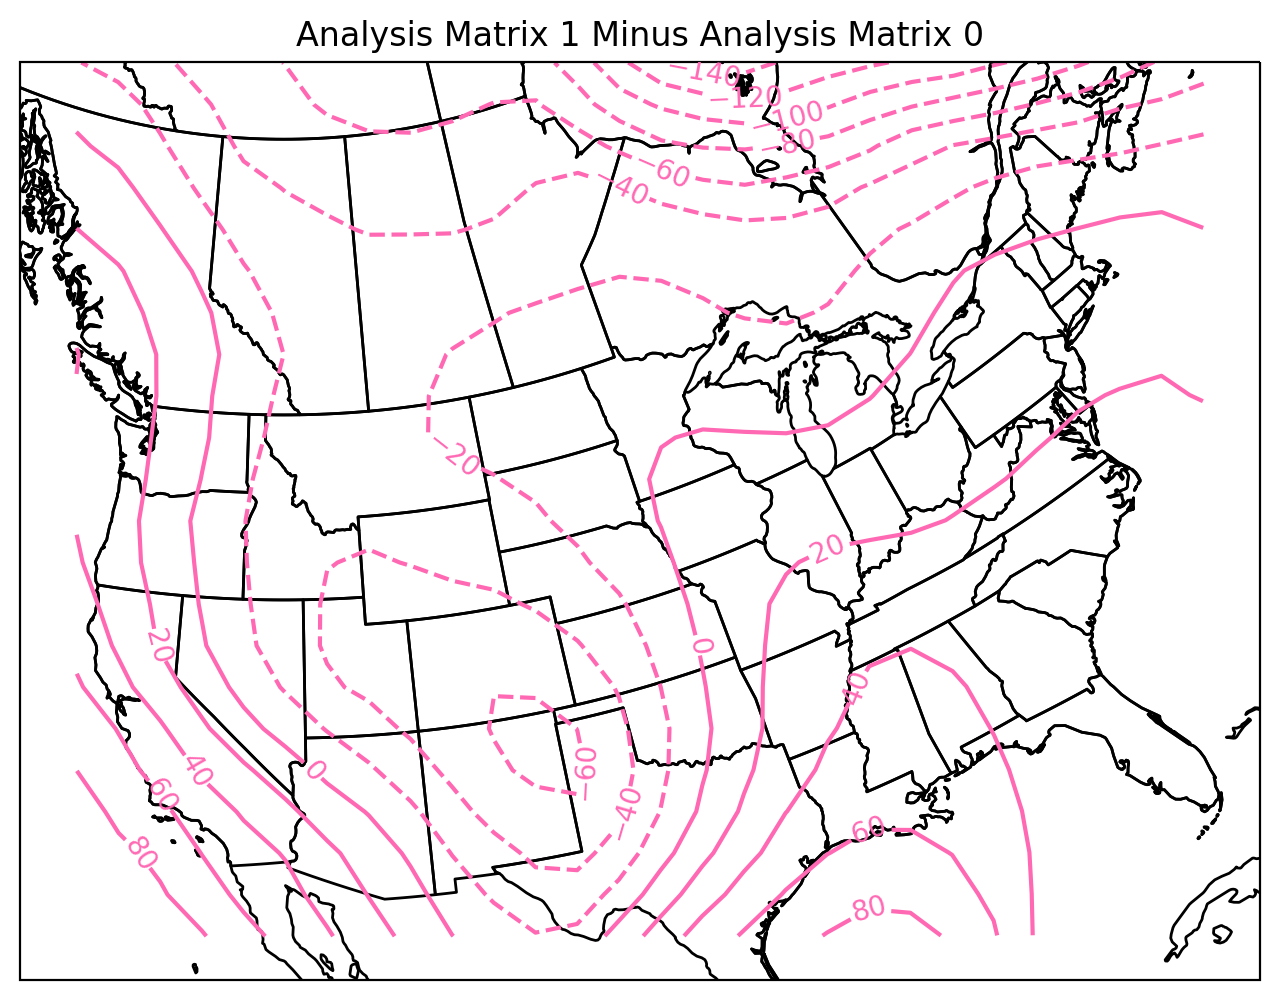

In [26]:
#Finding the Analysis matrix differences 
#Analysis 1 - 0
analysis1_minus_0 = analysis_matrix[:,:,1] -analysis_matrix[:,:,0]
analysis1_minus_0
### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis1_minus_0[:,:],colors='hotpink',levels = np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(-8000,8000,20))
plt.title("Analysis Matrix 1 Minus Analysis Matrix 0")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/02-Successive_Corrections/Analysis_dif_1_minus_0.png')

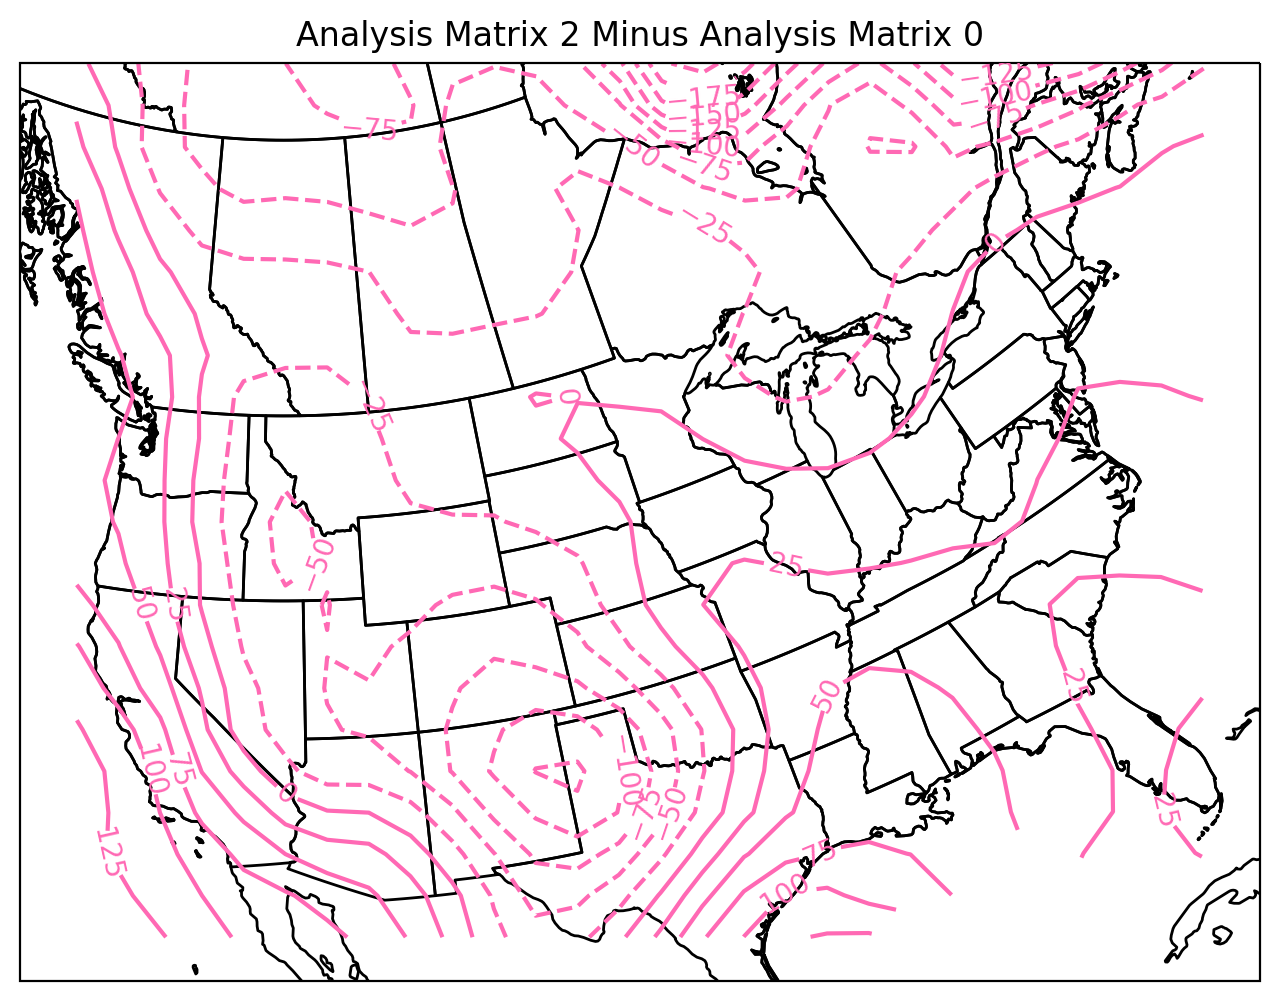

In [37]:
#Analysis 2 - 0
analysis2_minus_0 = analysis_matrix[:,:,2] -analysis_matrix[:,:,0]
analysis2_minus_0
### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis2_minus_0[:,:],colors='hotpink',levels = np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(-8000,8000,25))
plt.title("Analysis Matrix 2 Minus Analysis Matrix 0")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/02-Successive_Corrections/Analysis_dif_2_minus_0.png')

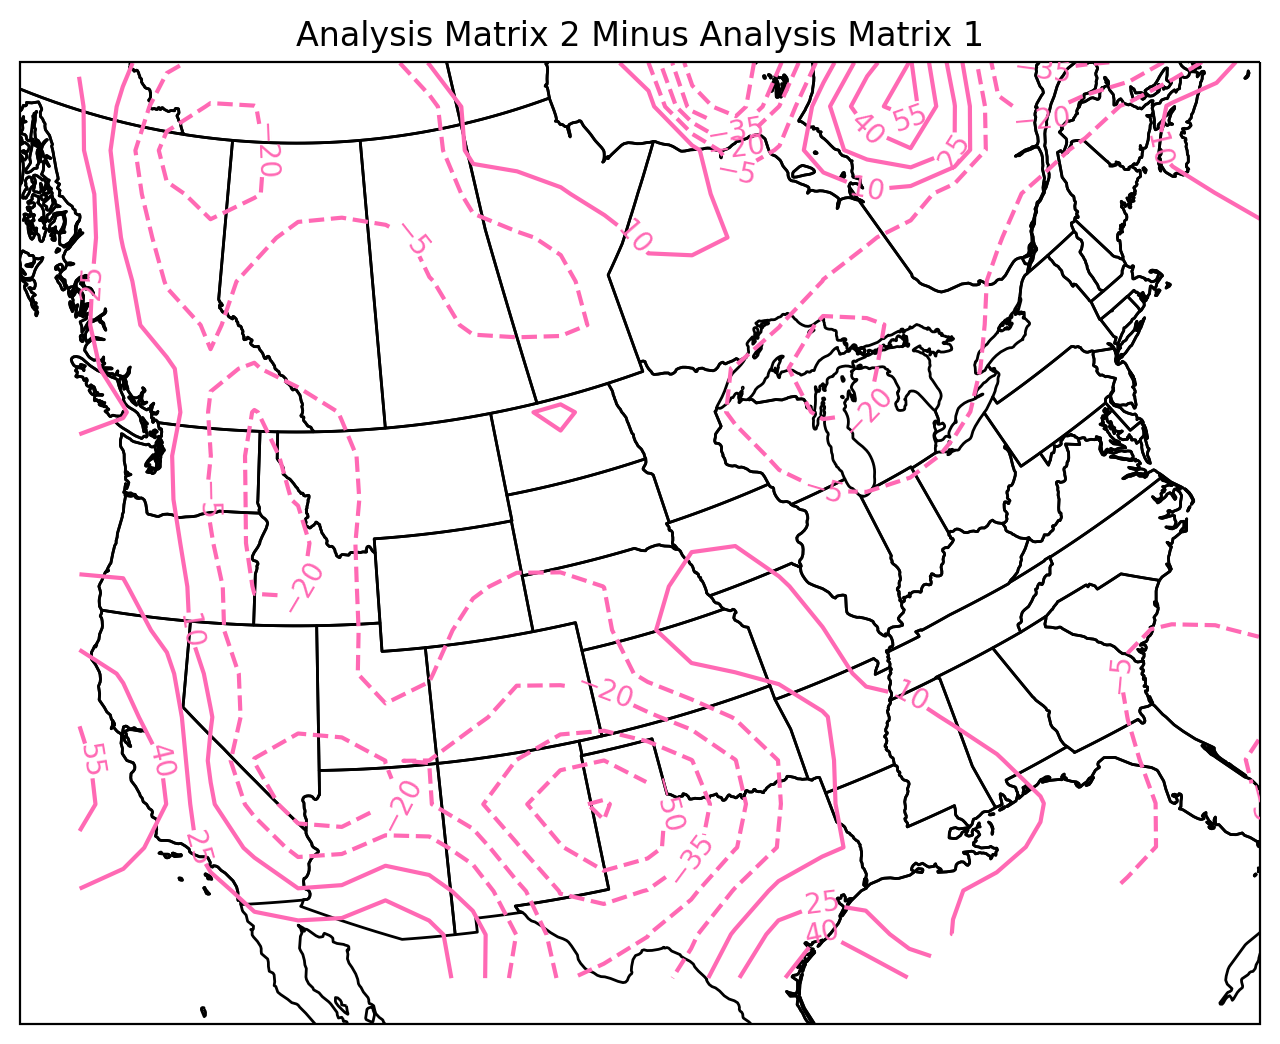

In [38]:
#Analysis 2 - 1
analysis2_minus_1 = analysis_matrix[:,:,2] -analysis_matrix[:,:,1]
analysis2_minus_1
### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis2_minus_1[:,:],colors='hotpink',levels = np.arange(-8000,8000,15),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(-8000,8000,15))
plt.title("Analysis Matrix 2 Minus Analysis Matrix 1")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/02-Successive_Corrections/Analysis_dif_2_minus_1.png')

In [ ]:
#Compute the root mean square difference between the analyses and observations for each analysis pass.
#fo is the heights and it correlates to the fo in the equation 
difference_1 = (fobs - bilinear_result)**2
difference_1 = difference_1[~np.isnan(difference_1)]
rms_1 = np.sqrt(np.sum(difference_1/len(difference_1)))
print(rms_1)

difference_2 = (fobs - bilinear_result2)**2
difference_2 = difference_2[~np.isnan(difference_2)]
rms_2 = np.sqrt(np.sum(difference_2/len(difference_2)))
print(rms_2)

difference_3 = (fobs - bilinear_result3)**2
difference_3 = difference_3[~np.isnan(difference_3)]
rms_3 = np.sqrt(np.sum(difference_3/len(difference_3)))
print(rms_3)

rms_vals = list([rms_1,rms_2, rms_3])

In [29]:
### Store the analyses in text files ###
#Saving the matrices as text files.
#np.savetxt("First_pass.txt", analysis_matrix[:,:,0], delimiter = ',')
#np.savetxt("Second_pass.txt", analysis_matrix[:,:,1], delimiter = ',')
#np.savetxt("Third_pass.txt", analysis_matrix[:,:,2], delimiter = ',')

In [30]:
### Store the difference fields in text files ###
#np.savetxt("analysis_difference_1_0.txt", analysis1_minus_0[:,:], delimiter = ',')
#np.savetxt("analysis_difference_2_0.txt", analysis2_minus_0[:,:], delimiter = ',')
#np.savetxt("analysis_difference_2_1.txt", analysis2_minus_1[:,:], delimiter = ',')

In [36]:
### Store RMS values in text file ###
#np.savetxt("RMS_VALS.txt", rms_vals)

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
 

1 - Describe the general features that you see in your contoured analyses. 

    The general features observed in each plot are a trough located over the western half of the United States, that drops down into the New Mexico and Arizona region. 
    A ridge is present over the Mid-Western and East Coast. The overall contours look like a cosine wave. As you increase the number of passes more noise and smaller scale features become 
    apparent and the overall shape of the trough and ridge are more defined and not as smoothed out as the first pass. 

 
 

2 - Describe the differences that you see in your contoured analyses.   

    Does one analysis seem to be smoother than the other?  If so, what would cause this? 

    As you increase the number of passes the features are no longer as smooth as they originally were. You are picking up the higher frequency patterns and not just the large-scale patterns. 
    As the passes increased weirder features became apparent. For example, there is an odd-looking lightning bolt feature off the coast of Florida within the Gulf of Mexico. 
    The first analysis is the smoothest of the plots and represents primarily the large-scale weather pattern and little to none of the smaller more regional patterns. 
    The first analysis is smoother because it has the largest ROI and with successive corrections the more iterations you do the more and more the analysis points converge to the observations. 
    As you have a smaller and smaller ROI the points included are going to be less and less and you are going to start aligning with those points more readily as there is fewer points 
    influencing I (locally the points will look like the observations). 



3 - What happens as you increase the number of successive corrections passes?  Is this  

    desirable?  Why or why not? 

    The more you increase the number of successive corrections the more and more the analysis points align to the observations. 
    This is only desirable when there is no background, and the observations are perfect. If the observations are not perfect, you will be converging to bad analysis values, and no one wants that. 

'''